## Introduction
The purpose of this notebook is to develop a hueristic extraction method for sentences prescribing some allowable action, i.e., 'permission statments' from a corpus of informed consent forms. These extractions are to be evaluated using human annotators. From these evalutations we will develop a text classifier to automate the process of permission extraction.

### Authors: Cooper Stansbury, Anish Pavaskar, Krishan Amin

## Set-up and Notebook Configuration

In [1]:
from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

VERSION:  3.7.0


In [2]:
# Fundamentals
import os
import re
import pandas as pd
import numpy as np
from itertools import chain
import csv
import datetime

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt

# NLP and related tools
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
from spacy.vocab import Vocab
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

# custom data functions
import load_data
import clean_data

In [3]:
# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

## Semantic Clues
These are the verbs that we believe indicate the prescence of a statement of 'allowable action.'

Taken from: 

```
“I found synonyms for ‘permission’ on the new Thesaurus.com!,”
www.thesaurus.com. [Online]. Available: https://www.thesaurus.com/browse/permission. 
[Accessed: 19-Feb-2019].
```

In [5]:
semantic_bases = ["permission", 
                "authorization", 
                "authorize",
                "consent",
                "assent",
                "permit",
                "approve",
                "agree",
                "grant",
                "allow",
                "certify"]

## Print Base Definitions

In [6]:
def printWordNetDefinitions(wordList):
    """ return wordnet definitions for a given list """
    
    for word in wordList:
        syns = wordnet.synsets(word)
        print(word, ":")
        count = 0
        for word_sense in syns:
            count += 1
            print("  ", count, ":", word_sense.definition())
    

In [7]:
printWordNetDefinitions(semantic_bases)

permission :
   1 : approval to do something
   2 : the act of giving a formal (usually written) authorization
authorization :
   1 : a document giving an official instruction or command
   2 : the power or right to give orders or make decisions
   3 : official permission or approval
   4 : the act of conferring legality or sanction or formal warrant
authorize :
   1 : grant authorization or clearance for
   2 : give or delegate power or authority to
consent :
   1 : permission to do something
   2 : give an affirmative reply to; respond favorably to
assent :
   1 : agreement with a statement or proposal to do something
   2 : to agree or express agreement
permit :
   1 : a legal document giving official permission to do something
   2 : the act of giving a formal (usually written) authorization
   3 : large game fish; found in waters of the West Indies
   4 : consent to, give permission
   5 : make it possible through a specific action or lack of action for something to happen
   6 : 

## Add Synonyms
Use WordNet to gather synonyms of the semantic clues.

In [8]:
def addWordNetSynsets(word_list):
    """  add synsets to new list """
    updated_list = []
    
    for word in word_list:
        updated_list.append(word)
        
        v_synonyms = wordnet.synsets(word, "v")
        v_synonyms = set(chain.from_iterable([word.lemma_names() for word in v_synonyms]))
        
        [updated_list.append(x) for x in v_synonyms if x not in updated_list]
        
    print('Found: ', len(set(updated_list)), ' total clues')
    return set(updated_list)

In [9]:
%%time
# expect 65
extended_semantic_clues = addWordNetSynsets(semantic_bases)

Found:  65  total clues
CPU times: user 573 µs, sys: 75 µs, total: 648 µs
Wall time: 624 µs


## Check Clue Similarities
Turns out not to be very helpful, likely because those words that aren't, on average, as similar have more definitions than those like 'permit,' which have only a few specified uses in the English language, this is evidenced in the standard deviations.

In [10]:
clue_similarity_matrix = pd.DataFrame(index=extended_semantic_clues, 
                                      columns=extended_semantic_clues)

for index, row in clue_similarity_matrix.iterrows():
    for base in extended_semantic_clues:
        base_syn = wordnet.synsets(base)
        index_syn = wordnet.synsets(index)
        sim = wordnet.wup_similarity(index_syn[0], base_syn[0])
        
        if sim != None:
            row[base] = wordnet.wup_similarity(index_syn[0], base_syn[0])
        else:
            row[base] = 0.0
        
clue_similarity_matrix = clue_similarity_matrix.astype(float)

Unfortunately, this doesn't help us automate 'culling' of terms we don't really like.

In [11]:
clue_similarity_matrix.describe(include = 'all').transpose().sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
sanction,65.0,0.293732,0.205292,0.117647,0.166667,0.222222,0.307692,1.0
permission,65.0,0.291366,0.198704,0.117647,0.166667,0.222222,0.307692,1.0
okay,65.0,0.276665,0.205287,0.111111,0.153846,0.200000,0.285714,1.0
O.K.,65.0,0.276665,0.205287,0.111111,0.153846,0.200000,0.285714,1.0
consent,65.0,0.272269,0.192199,0.111111,0.153846,0.200000,0.285714,1.0
gibe,65.0,0.267366,0.183537,0.111111,0.153846,0.200000,0.285714,1.0
jibe,65.0,0.267366,0.183537,0.111111,0.153846,0.200000,0.285714,1.0
license,65.0,0.263719,0.208395,0.105263,0.142857,0.181818,0.266667,1.0
permit,65.0,0.263719,0.208395,0.105263,0.142857,0.181818,0.266667,1.0
manifest,65.0,0.261796,0.201972,0.105263,0.142857,0.181818,0.266667,1.0


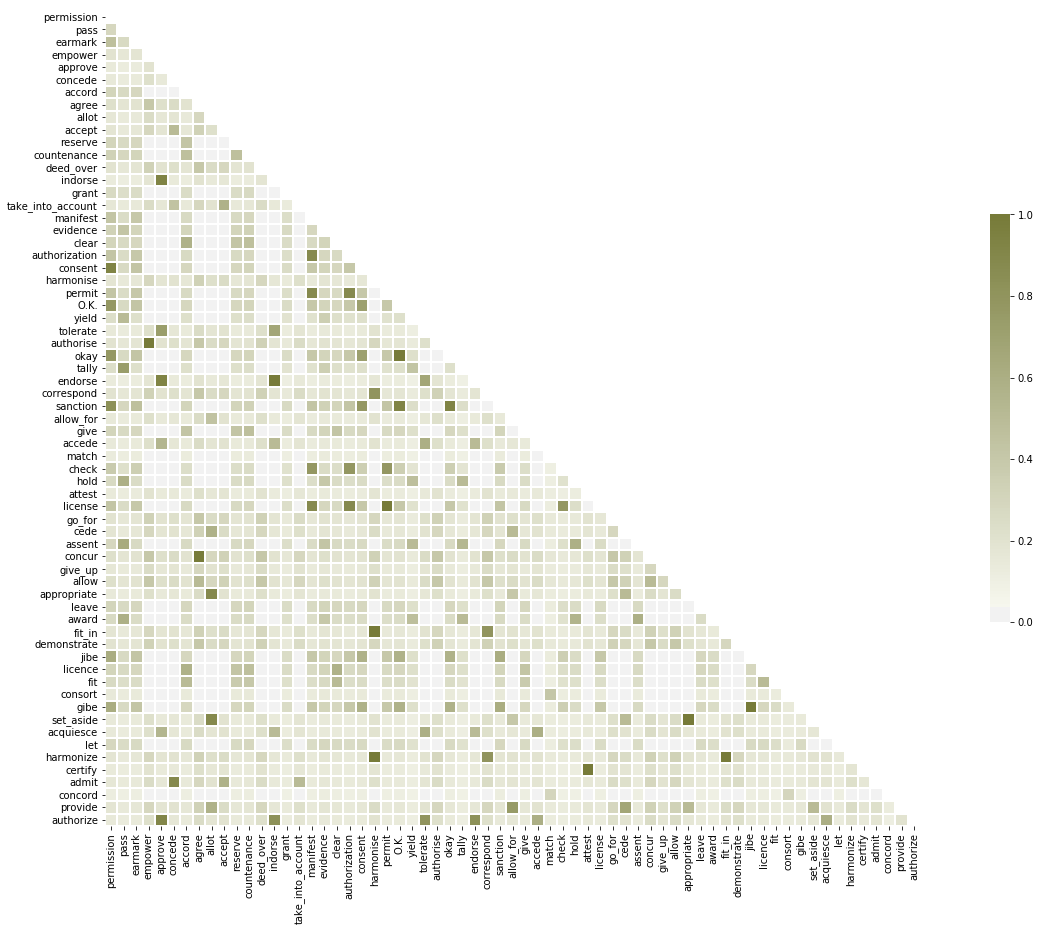

In [12]:
%matplotlib inline

mask = np.zeros_like(clue_similarity_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(25, 15), facecolor='w')
cmap = sns.diverging_palette(230, 90, as_cmap=True)

sns.heatmap(clue_similarity_matrix, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .5})

## Remove Inapproriate Clues

Here we define a list of terms we will remove from the semantic clues.

In [13]:
"""
Define a list to remove selected words from the semantic clues. 
WordNet has it's weaknesses.
"""
poorly_fitting_semantic_clues = {
     'manifest',
     'harmonise',
     'gibe',
     'harmonize',
     'yield',
     'allot',
     'demonstrate',
     'endorse',
     'take_into_account',
     'allow_for',
     'set_aside',
     'clear',
     'acquiesce',
     'indorse',
     'go_for',
     'earmark',
     'license',
     'reserve',
     'pass',
     'tolerate',
     'O.K.',
     'deed_over',
     'award',
     'evidence',
     'appropriate',
     'leave',
     'give_up',
     'empower',
     'okay',
     'countenance',
     'fit_in',
     'correspond',
     'hold',
     'concord',
     'match',
     'jibe',
     'fit',
     'tally',
     'consort',
}

In [14]:
# XOR power
permission_extended = list(poorly_fitting_semantic_clues ^ extended_semantic_clues)

In [15]:
# expect 26
print('num terms after culling: ', len(permission_extended), '\n')

num terms after culling:  26 



Let's check the definitions, just to make sure we agree that each clue belongs. Note, at this points we aren't using each definition (or word sense for the clue). We are only performing string matching with the semantic clue. We just want a sanity check here.

In [16]:
printWordNetDefinitions(permission_extended)

approve :
   1 : give sanction to
   2 : judge to be right or commendable; think well of
accord :
   1 : harmony of people's opinions or actions or characters
   2 : concurrence of opinion
   3 : a written agreement between two states or sovereigns
   4 : sympathetic compatibility
   5 : go together
   6 : allow to have
accept :
   1 : consider or hold as true
   2 : receive willingly something given or offered
   3 : give an affirmative reply to; respond favorably to
   4 : react favorably to; consider right and proper
   5 : admit into a group or community
   6 : take on as one's own the expenses or debts of another person
   7 : tolerate or accommodate oneself to
   8 : be designed to hold or take
   9 : receive (a report) officially, as from a committee
   10 : make use of or accept for some purpose
   11 : be sexually responsive to, used of a female domesticated mammal
grant :
   1 : any monetary aid
   2 : the act of providing a subsidy
   3 : (law) a transfer of property by deed

## Import Data
Det dataframe for each consent for in `data/`

In [17]:
# Data location
forms_dir = '../data/raw/all_forms'

In [18]:
%%time

"""
NOTE: running this cell will re-load the data in the dataframe from the dir.
"""
# run the function and store to variable 
raw_df = load_data.getDIRData(forms_dir)

# set the index as the id, for future access
raw_df = raw_df.set_index('id')
raw_df.head()

CPU times: user 214 ms, sys: 140 ms, total: 353 ms
Wall time: 1.18 s


## How Many do We have?

In [19]:
len(raw_df)

752

## Random sampling to speed up development
This will be removed when we want to process the whole corpus.

In [20]:
# comment out to run on whole document collection
n_samples = 200
df = raw_df.sample(n=n_samples, random_state=1729)

## Add Clean Text To DataFrame

Notes: by forcing `ascii` encoding we strip non-english characters (which do exist).

In [21]:
from_field = 'rawText'
copy_to = 'minimalCleaning'

df[copy_to] = df.apply(lambda row:clean_data.minimalTextCleaning(row, from_field),axis=1)

In [22]:
df.head()

,name,path,rawText,minimalCleaning
id,,,,
370,Queensland_AUSTRALIA_ Immunization Consent For...,../data/raw/all_forms/Queensland_AUSTRALIA_ Im...,Gold Coast Health | Public Health Unit School...,gold coast health | public health unit school ...
490,MinorAssentForm030708 (1).txt,../data/raw/all_forms/MinorAssentForm030708 (1...,﻿\t\t TUFTS MEDICAL CENTER TUFTS UNIVERSITY De...,tufts medical center tufts university departme...
300,ICS_Line Insertion.txt,../data/raw/all_forms/ICS_Line Insertion.txt,"I nfusion C are S ervices of Virginia, In...","i nfusion c are s ervices of virginia, inc. in..."
565,Cambridge_Consent_endodontics11.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,CONSENT FOR ROOT CANAL TREATMENT I hereby auth...,consent for root canal treatment i hereby auth...
554,HSE Ireland_Influenza Vaccine Consent Form.txt,../data/raw/all_forms/HSE Ireland_Influenza Va...,Healthcare Staff Seasonal Influenza Vaccinatio...,healthcare staff seasonal influenza vaccinatio...


In [23]:
df['rawText'].iloc[1][:1000]

'\ufeff\t\t TUFTS MEDICAL CENTER TUFTS UNIVERSITY Department name  AGREEMENT TO PARTICIPATE IN RESEARCH   Title of study  Principal Investigator: Co-Investigators:  We are inviting you to take part in a research study we are doing.  A research study is a way to learn about something in medicine.  We would like to find out more about (state study topic and describe in simple language).   We are inviting you to be in the study because you (state reason(s) for inclusion).  If you agree to take part this study, we will ask you to (describe/explain procedures in simple words that the age group to be enrolled would know and understand.  State in language appropriate for the age group the number of visits and how long visits will last).  Explain the possible risks in simple words that the age group to be enrolled would know and understand.  Explain the possible benefits; include one of the following as appropriate to the study:  This study will help us learn more about (use simple words that 

In [24]:
df['minimalCleaning'].iloc[1][:1000]

'tufts medical center tufts university department name agreement to participate in research title of study principal investigator: co-investigators: we are inviting you to take part in a research study we are doing. a research study is a way to learn about something in medicine. we would like to find out more about (state study topic and describe in simple language). we are inviting you to be in the study because you (state reason(s) for inclusion). if you agree to take part this study, we will ask you to (describe/explain procedures in simple words that the age group to be enrolled would know and understand. state in language appropriate for the age group the number of visits and how long visits will last). explain the possible risks in simple words that the age group to be enrolled would know and understand. explain the possible benefits; include one of the following as appropriate to the study: this study will help us learn more about (use simple words that the age group to be enrol

## Convert Text to Spacy Object
We have tried converting the raw text, but this empirically did not allow for quality sentence parsing. Defaulting instead to clean only for now.

## NOTE: This is a bottleneck (slow execution time).

In [25]:
%%time

convertFrom = 'minimalCleaning'
convertTo = 'DOC'

df[convertTo] = df.apply(lambda row:clean_data.getDocObjects(row, convertFrom),axis=1)

CPU times: user 1min 41s, sys: 21.4 s, total: 2min 3s
Wall time: 1min 9s


In [26]:
df.head()

,name,path,rawText,minimalCleaning,DOC
id,,,,,
370,Queensland_AUSTRALIA_ Immunization Consent For...,../data/raw/all_forms/Queensland_AUSTRALIA_ Im...,Gold Coast Health | Public Health Unit School...,gold coast health | public health unit school ...,"(gold, coast, health, |, public, health, unit,..."
490,MinorAssentForm030708 (1).txt,../data/raw/all_forms/MinorAssentForm030708 (1...,﻿\t\t TUFTS MEDICAL CENTER TUFTS UNIVERSITY De...,tufts medical center tufts university departme...,"(tufts, medical, center, tufts, university, de..."
300,ICS_Line Insertion.txt,../data/raw/all_forms/ICS_Line Insertion.txt,"I nfusion C are S ervices of Virginia, In...","i nfusion c are s ervices of virginia, inc. in...","(i, nfusion, c, are, s, ervices, of, virginia,..."
565,Cambridge_Consent_endodontics11.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,CONSENT FOR ROOT CANAL TREATMENT I hereby auth...,consent for root canal treatment i hereby auth...,"(consent, for, root, canal, treatment, i, here..."
554,HSE Ireland_Influenza Vaccine Consent Form.txt,../data/raw/all_forms/HSE Ireland_Influenza Va...,Healthcare Staff Seasonal Influenza Vaccinatio...,healthcare staff seasonal influenza vaccinatio...,"(healthcare, staff, seasonal, influenza, vacci..."


## Extract all Sentences
We want a list of all sentences from the spaCy doc objects (token.span). We are defining a 'sentence' as the unit of text we care about. Defualt to spaCy performance on parsing. Need to investigate.

In [27]:
getFrom = 'DOC'
convertTo = 'sentenceList'

df[convertTo] = df.apply(lambda row:clean_data.getSentenceList(row, getFrom),axis=1)

In [28]:
df.head()

,name,path,rawText,minimalCleaning,DOC,sentenceList
id,,,,,,
370,Queensland_AUSTRALIA_ Immunization Consent For...,../data/raw/all_forms/Queensland_AUSTRALIA_ Im...,Gold Coast Health | Public Health Unit School...,gold coast health | public health unit school ...,"(gold, coast, health, |, public, health, unit,...","[(gold, coast, health, |, public, health, unit..."
490,MinorAssentForm030708 (1).txt,../data/raw/all_forms/MinorAssentForm030708 (1...,﻿\t\t TUFTS MEDICAL CENTER TUFTS UNIVERSITY De...,tufts medical center tufts university departme...,"(tufts, medical, center, tufts, university, de...","[(tufts, medical, center, tufts, university, d..."
300,ICS_Line Insertion.txt,../data/raw/all_forms/ICS_Line Insertion.txt,"I nfusion C are S ervices of Virginia, In...","i nfusion c are s ervices of virginia, inc. in...","(i, nfusion, c, are, s, ervices, of, virginia,...","[(i, nfusion), (c, are, s, ervices, of, virgin..."
565,Cambridge_Consent_endodontics11.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,CONSENT FOR ROOT CANAL TREATMENT I hereby auth...,consent for root canal treatment i hereby auth...,"(consent, for, root, canal, treatment, i, here...","[(consent, for, root, canal, treatment, i, her..."
554,HSE Ireland_Influenza Vaccine Consent Form.txt,../data/raw/all_forms/HSE Ireland_Influenza Va...,Healthcare Staff Seasonal Influenza Vaccinatio...,healthcare staff seasonal influenza vaccinatio...,"(healthcare, staff, seasonal, influenza, vacci...","[(healthcare, staff, seasonal, influenza, vacc..."


## Sanity Check
Let's look at a few sentences. Note, these are just teh first few of the first few randomly sampled documents, don't draw any conclusions yet.

In [29]:
for list_of_setences in df['sentenceList'].head(5):
    print("-----------------\n")
    for sentence in list_of_setences[:5]:
        print(sentence, '\n')

-----------------

gold coast health | public health unit school immunisation program consent form year 7 school class student details surname given names date of birth / / gender male medicare 

no. 

female reference no. 

on card home address state suburb 

yes does your child identify as either aboriginal or torres strait islander if yes, please select one of the following: aboriginal is english your family's main language spoken at home no torres strait islander (tsi) 

-----------------

tufts medical center tufts university department name agreement to participate in research title of study principal investigator: co-investigators: we are inviting you to take part in a research study we are doing. 

a research study is a way to learn about something in medicine. 

we would like to find out more about (state study topic and describe in simple language). 

we are inviting you to be in the study because you (state reason(s) for inclusion). 

if you agree to take part this study, we

## Strip short sentences

I think that the shortest sentence we care about is `I consent.` As a preprocessing function we remove sentences below a specific character length threshold (in the second cell below). This reduces the number of string matches we need to perform moving forward.

In [30]:
def removeShortSentences(row, field, length_threshold):
    """  remove extremely short sentences, as they are likely not helpful """
    
    stripped_sent = []
    
    for sentence in row[field]:
        if len(sentence.text) >= length_threshold:
            stripped_sent.append(sentence)
            
    return stripped_sent

In [31]:
getFrom = 'sentenceList'
convertTo = getFrom + '_stripped'
preliminary_sentence_length_thresh = len('i consent')

df[convertTo] = df.apply(lambda row:removeShortSentences(row, getFrom, preliminary_sentence_length_thresh),axis=1)

In [32]:
df.head()

,name,path,rawText,minimalCleaning,DOC,sentenceList,sentenceList_stripped
id,,,,,,,
370,Queensland_AUSTRALIA_ Immunization Consent For...,../data/raw/all_forms/Queensland_AUSTRALIA_ Im...,Gold Coast Health | Public Health Unit School...,gold coast health | public health unit school ...,"(gold, coast, health, |, public, health, unit,...","[(gold, coast, health, |, public, health, unit...","[(gold, coast, health, |, public, health, unit..."
490,MinorAssentForm030708 (1).txt,../data/raw/all_forms/MinorAssentForm030708 (1...,﻿\t\t TUFTS MEDICAL CENTER TUFTS UNIVERSITY De...,tufts medical center tufts university departme...,"(tufts, medical, center, tufts, university, de...","[(tufts, medical, center, tufts, university, d...","[(tufts, medical, center, tufts, university, d..."
300,ICS_Line Insertion.txt,../data/raw/all_forms/ICS_Line Insertion.txt,"I nfusion C are S ervices of Virginia, In...","i nfusion c are s ervices of virginia, inc. in...","(i, nfusion, c, are, s, ervices, of, virginia,...","[(i, nfusion), (c, are, s, ervices, of, virgin...","[(i, nfusion), (c, are, s, ervices, of, virgin..."
565,Cambridge_Consent_endodontics11.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,CONSENT FOR ROOT CANAL TREATMENT I hereby auth...,consent for root canal treatment i hereby auth...,"(consent, for, root, canal, treatment, i, here...","[(consent, for, root, canal, treatment, i, her...","[(consent, for, root, canal, treatment, i, her..."
554,HSE Ireland_Influenza Vaccine Consent Form.txt,../data/raw/all_forms/HSE Ireland_Influenza Va...,Healthcare Staff Seasonal Influenza Vaccinatio...,healthcare staff seasonal influenza vaccinatio...,"(healthcare, staff, seasonal, influenza, vacci...","[(healthcare, staff, seasonal, influenza, vacc...","[(healthcare, staff, seasonal, influenza, vacc..."


## Another Sanity Check

In [33]:
for list_of_setences in df['sentenceList_stripped'].head(5):
    print("-----------------\n")
    for sentence in list_of_setences[:5]:
        print(sentence, '\n')

-----------------

gold coast health | public health unit school immunisation program consent form year 7 school class student details surname given names date of birth / / gender male medicare 

female reference no. 

on card home address state suburb 

yes does your child identify as either aboriginal or torres strait islander if yes, please select one of the following: aboriginal is english your family's main language spoken at home no torres strait islander (tsi) 

yes postcode both aboriginal and tsi 

-----------------

tufts medical center tufts university department name agreement to participate in research title of study principal investigator: co-investigators: we are inviting you to take part in a research study we are doing. 

a research study is a way to learn about something in medicine. 

we would like to find out more about (state study topic and describe in simple language). 

we are inviting you to be in the study because you (state reason(s) for inclusion). 

if you 

## Check Removal of Sents
Here we check to see how many sentences were removed using thresholding.

In [34]:
for index, row in df.head(5).iterrows():
    print('Doc ID: ', index, 'number of all sentences: ', 
          len(row['sentenceList']))
    print('Doc ID: ', index, 'number of sentences after short sentences:',
          len(row['sentenceList_stripped']))
    print()

Doc ID:  370 number of all sentences:  33
Doc ID:  370 number of sentences after short sentences: 28

Doc ID:  490 number of all sentences:  22
Doc ID:  490 number of sentences after short sentences: 22

Doc ID:  300 number of all sentences:  19
Doc ID:  300 number of sentences after short sentences: 19

Doc ID:  565 number of all sentences:  29
Doc ID:  565 number of sentences after short sentences: 28

Doc ID:  554 number of all sentences:  17
Doc ID:  554 number of sentences after short sentences: 13



## String matching Extraction
Generate candidates by finding all sentences in each document that contain at least one of the semantic clues we care about. Note, this will generate a large number of false positives, which we expect.

In [35]:
def getPossiblePermissions(row, permissions_list, getCandidates_from):
    """ return list of sentences containing the 
    permissions words """
    
    candidates = []
    
    # iterate through a list of sentences
    for sent in row[getCandidates_from]:
        
        # iterate through each clue
        for clue in permissions_list:     
            
            # check if sting contains any clues (need to match case)
            if sent.text.__contains__(clue):
                """ NOTE: right not if ANY clue is found, this is enough """
                
                candidates.append(sent)
    
    return candidates

In [36]:
getCandidates_from = 'sentenceList_stripped'
to = 'Preliminary_CANDIDATES'

df[to] = df.apply(lambda row:getPossiblePermissions(row, permission_extended, getCandidates_from),axis=1)

In [37]:
df.head()

,name,path,rawText,minimalCleaning,DOC,sentenceList,sentenceList_stripped,Preliminary_CANDIDATES
id,,,,,,,,
370,Queensland_AUSTRALIA_ Immunization Consent For...,../data/raw/all_forms/Queensland_AUSTRALIA_ Im...,Gold Coast Health | Public Health Unit School...,gold coast health | public health unit school ...,"(gold, coast, health, |, public, health, unit,...","[(gold, coast, health, |, public, health, unit...","[(gold, coast, health, |, public, health, unit...","[(gold, coast, health, |, public, health, unit..."
490,MinorAssentForm030708 (1).txt,../data/raw/all_forms/MinorAssentForm030708 (1...,﻿\t\t TUFTS MEDICAL CENTER TUFTS UNIVERSITY De...,tufts medical center tufts university departme...,"(tufts, medical, center, tufts, university, de...","[(tufts, medical, center, tufts, university, d...","[(tufts, medical, center, tufts, university, d...","[(tufts, medical, center, tufts, university, d..."
300,ICS_Line Insertion.txt,../data/raw/all_forms/ICS_Line Insertion.txt,"I nfusion C are S ervices of Virginia, In...","i nfusion c are s ervices of virginia, inc. in...","(i, nfusion, c, are, s, ervices, of, virginia,...","[(i, nfusion), (c, are, s, ervices, of, virgin...","[(i, nfusion), (c, are, s, ervices, of, virgin...","[((, office, ), 757, -, 410, -, 4068, (, fax, ..."
565,Cambridge_Consent_endodontics11.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,CONSENT FOR ROOT CANAL TREATMENT I hereby auth...,consent for root canal treatment i hereby auth...,"(consent, for, root, canal, treatment, i, here...","[(consent, for, root, canal, treatment, i, her...","[(consent, for, root, canal, treatment, i, her...","[(consent, for, root, canal, treatment, i, her..."
554,HSE Ireland_Influenza Vaccine Consent Form.txt,../data/raw/all_forms/HSE Ireland_Influenza Va...,Healthcare Staff Seasonal Influenza Vaccinatio...,healthcare staff seasonal influenza vaccinatio...,"(healthcare, staff, seasonal, influenza, vacci...","[(healthcare, staff, seasonal, influenza, vacc...","[(healthcare, staff, seasonal, influenza, vacc...","[(healthcare, staff, seasonal, influenza, vacc..."


In [38]:
sentList = 'sentenceList_stripped'
candidates = 'Preliminary_CANDIDATES'
to = 'CANDIDATES'

def add_I_Candidates(row, sentList, candidates):
    """ add sentences with the word 'I' to the candidates """
    
    expanded_candidates = row[candidates]
    
    # iterate through a list of sentences
    for sent in row[sentList]:
        for word in sent:
            if word.pos_ == 'PRON':
                expanded_candidates.append(sent)
                
    return list(set(expanded_candidates))
        
df[to] = df.apply(lambda row:add_I_Candidates(row, sentList, candidates),axis=1)

### Sanity Check

In [39]:
for sent in df['CANDIDATES'].head(5):
    [print(x.text, '\n') for x in sent[:2]]

no, i do not consent because: date: my child will recieve vaccine from the family doctor / 

vaccination consent form / v2018 gold coast health | public health unit school immunisation program consent form year 7 consent for vaccination: parent/legal guardian to read and sign i am authorised as the parent or legal guardian of the listed child to give consent for the child to be vaccinated. 

you can say yes now and change your mind later. 

it is up to you. 

i fully understand that the insertion of a picc or midline is an invasive procedure which is accompanied by certain risks which include, but are not limited to, unsuccessful placement, local and/or systemic infection, irregular heart beats, catheter embolism, air embolism, hematoma at the insertion site, catheter tip malpositioning, phlebitis and thrombophlebitis. 

i fully understand that only an experience and qualified registered nurse or physician will perform the insertion of the picc or midline. 

the doctor has explained t

## Candidate Similarity
Note, the threshold has a huge impact on the number of returned sentences. Right now, we're interested in the most common 10% of sentences to the candidates we got hieristically.

#### IMPORTANT NOTE: 
We are comparing sentences from a single document against themselves. We do not compare all sentences from all documents for similarity. This means that documents will be biased by their represective 'styles.'

In [40]:
sim_threshold = .95

In [41]:
candidates = 'CANDIDATES'
similar_tos = 'sentenceList_stripped'
add_to = 'EXPANDED_' + candidates + "_" + str(sim_threshold)

def getSimilars(row, field, candidates, threshold):
    """  get sentences that are similar (COS) to those candidates we have  """
    
    expanded_candidates = []
    
    for sentence in row[field]:
        for candidate_permission in row[candidates]:
            expanded_candidates.append(candidate_permission)
            if candidate_permission.similarity(sentence) >= threshold:
                expanded_candidates.append(sentence)
                
    return list(set(expanded_candidates)) # unique only 


df[add_to] = df.apply(lambda row:getSimilars(row, 
                                        similar_tos, 
                                        candidates, 
                                        sim_threshold),axis=1)

In [42]:
df.head()

,name,path,rawText,minimalCleaning,DOC,sentenceList,sentenceList_stripped,Preliminary_CANDIDATES,CANDIDATES,EXPANDED_CANDIDATES_0.95
id,,,,,,,,,,
370,Queensland_AUSTRALIA_ Immunization Consent For...,../data/raw/all_forms/Queensland_AUSTRALIA_ Im...,Gold Coast Health | Public Health Unit School...,gold coast health | public health unit school ...,"(gold, coast, health, |, public, health, unit,...","[(gold, coast, health, |, public, health, unit...","[(gold, coast, health, |, public, health, unit...","[(gold, coast, health, |, public, health, unit...","[(no, ,, i, do, not, consent, because, :, date...","[(no, ,, i, do, not, consent, because, :, date..."
490,MinorAssentForm030708 (1).txt,../data/raw/all_forms/MinorAssentForm030708 (1...,﻿\t\t TUFTS MEDICAL CENTER TUFTS UNIVERSITY De...,tufts medical center tufts university departme...,"(tufts, medical, center, tufts, university, de...","[(tufts, medical, center, tufts, university, d...","[(tufts, medical, center, tufts, university, d...","[(tufts, medical, center, tufts, university, d...","[(you, can, say, yes, now, and, change, your, ...","[(you, can, say, yes, now, and, change, your, ..."
300,ICS_Line Insertion.txt,../data/raw/all_forms/ICS_Line Insertion.txt,"I nfusion C are S ervices of Virginia, In...","i nfusion c are s ervices of virginia, inc. in...","(i, nfusion, c, are, s, ervices, of, virginia,...","[(i, nfusion), (c, are, s, ervices, of, virgin...","[(i, nfusion), (c, are, s, ervices, of, virgin...","[((, office, ), 757, -, 410, -, 4068, (, fax, ...","[(i, fully, understand, that, the, insertion, ...","[(i, fully, understand, that, the, insertion, ..."
565,Cambridge_Consent_endodontics11.txt,../data/raw/all_forms/Cambridge_Consent_endodo...,CONSENT FOR ROOT CANAL TREATMENT I hereby auth...,consent for root canal treatment i hereby auth...,"(consent, for, root, canal, treatment, i, here...","[(consent, for, root, canal, treatment, i, her...","[(consent, for, root, canal, treatment, i, her...","[(consent, for, root, canal, treatment, i, her...","[(the, doctor, has, explained, to, me, that, t...","[(the, doctor, has, explained, to, me, that, t..."
554,HSE Ireland_Influenza Vaccine Consent Form.txt,../data/raw/all_forms/HSE Ireland_Influenza Va...,Healthcare Staff Seasonal Influenza Vaccinatio...,healthcare staff seasonal influenza vaccinatio...,"(healthcare, staff, seasonal, influenza, vacci...","[(healthcare, staff, seasonal, influenza, vacc...","[(healthcare, staff, seasonal, influenza, vacc...","[(healthcare, staff, seasonal, influenza, vacc...","[(the, information, provided, will, be, includ...","[(the, information, provided, will, be, includ..."


In [43]:
for index, row in df.head(5).iterrows():
    print(index, 'total sentences (after stripping): ', 
      len(row['sentenceList_stripped']))
    
    print(index, 'original candidates: ', 
          len(row['CANDIDATES']))
    
    print(index, 'expanded candidates: ', 
          len(row['EXPANDED_CANDIDATES_0.95']))
    
    print(index, 'percentage of total (candidates): ', 
      len(row['EXPANDED_CANDIDATES_0.95'])/len(row['sentenceList_stripped']))
    print()

370 total sentences (after stripping):  28
370 original candidates:  19
370 expanded candidates:  20
370 percentage of total (candidates):  0.7142857142857143

490 total sentences (after stripping):  22
490 original candidates:  19
490 expanded candidates:  20
490 percentage of total (candidates):  0.9090909090909091

300 total sentences (after stripping):  19
300 original candidates:  13
300 expanded candidates:  13
300 percentage of total (candidates):  0.6842105263157895

565 total sentences (after stripping):  28
565 original candidates:  14
565 expanded candidates:  14
565 percentage of total (candidates):  0.5

554 total sentences (after stripping):  13
554 original candidates:  9
554 expanded candidates:  9
554 percentage of total (candidates):  0.6923076923076923



### Why so many FPs?

In [44]:
# check_index = 315

# for sent in df.at[check_index,'EXPANDED_CANDIDATES_0.95'][:20]:
#     print(sent, '\n')

## Sanity Check

In [45]:
for candidates in df['EXPANDED_CANDIDATES_0.95'].head(1):
    print('-------------\n')
    [print(x.text, '\n') for x in candidates[:3]]

-------------

no, i do not consent because: date: my child will recieve vaccine from the family doctor / 

vaccination consent form / v2018 gold coast health | public health unit school immunisation program consent form year 7 consent for vaccination: parent/legal guardian to read and sign i am authorised as the parent or legal guardian of the listed child to give consent for the child to be vaccinated. 

if i wish to change consent: - up to 2 business days before immunisation takes place at the school, i understand i need to do so by making a written request via email to gold coast public health unit at immunisegc@health.qld.gov.au 



## Get previous sentences (for context)

In [46]:
# for index, row in df.head(1).iterrows():
    
#     for cand in row['EXPANDED_CANDIDATES_0.95']:
#         candidate_idx = row['sentenceList'].index(cand)
#         previous_idx = candidate_idx - 1 
#         print(row['sentenceList'][previous_idx].text, "****" , 
#               row['sentenceList'][candidate_idx].text.upper(), "****\n")

## Some Quick Analysis Before we Export
We want to look at the position of the candidates with respect to normalized document length.

In [47]:
new_rows = []

for index, row in df.iterrows():
    normalized_positions = []
    
    for cand in row['EXPANDED_CANDIDATES_0.95']:
        first_match = row['sentenceList'].index(cand)
        normalized_pos = first_match/len(row['sentenceList'])
        normalized_positions.append(normalized_pos)
    
    sort_vec = sorted(normalized_positions)
    array_vec = np.asarray(sort_vec)
    
    for position in array_vec:
        row = {

            'id': index,
            'normalized_position_vector':array_vec,
            'pos': position
        }

        new_rows.append(row)
    
position_df = pd.DataFrame(new_rows)
position_df.head()

,id,normalized_position_vector,pos
0,370,"[0.0, 0.2727272727272727, 0.30303030303030304,...",0.000000
1,370,"[0.0, 0.2727272727272727, 0.30303030303030304,...",0.272727
2,370,"[0.0, 0.2727272727272727, 0.30303030303030304,...",0.303030
3,370,"[0.0, 0.2727272727272727, 0.30303030303030304,...",0.333333
4,370,"[0.0, 0.2727272727272727, 0.30303030303030304,...",0.363636


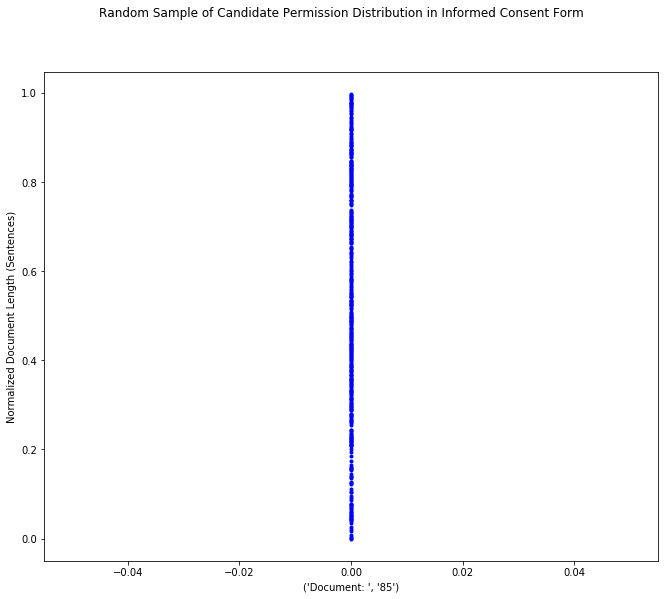

In [48]:
n_samples = 1
position_df_sample = position_df.sample(n=n_samples)

f, ax = plt.subplots(figsize=(11, 9), facecolor='w')

for i, row in position_df_sample.iterrows():
    x_axis = 'Document: ', str(row['id'])
    
    x = row['normalized_position_vector']
    y = np.zeros_like(x) + 0
    plt.plot(y, x, "b.")
    plt.suptitle('Random Sample of Candidate Permission Distribution in Informed Consent Form')
    plt.xlabel(x_axis)
    plt.ylabel('Normalized Document Length (Sentences)')

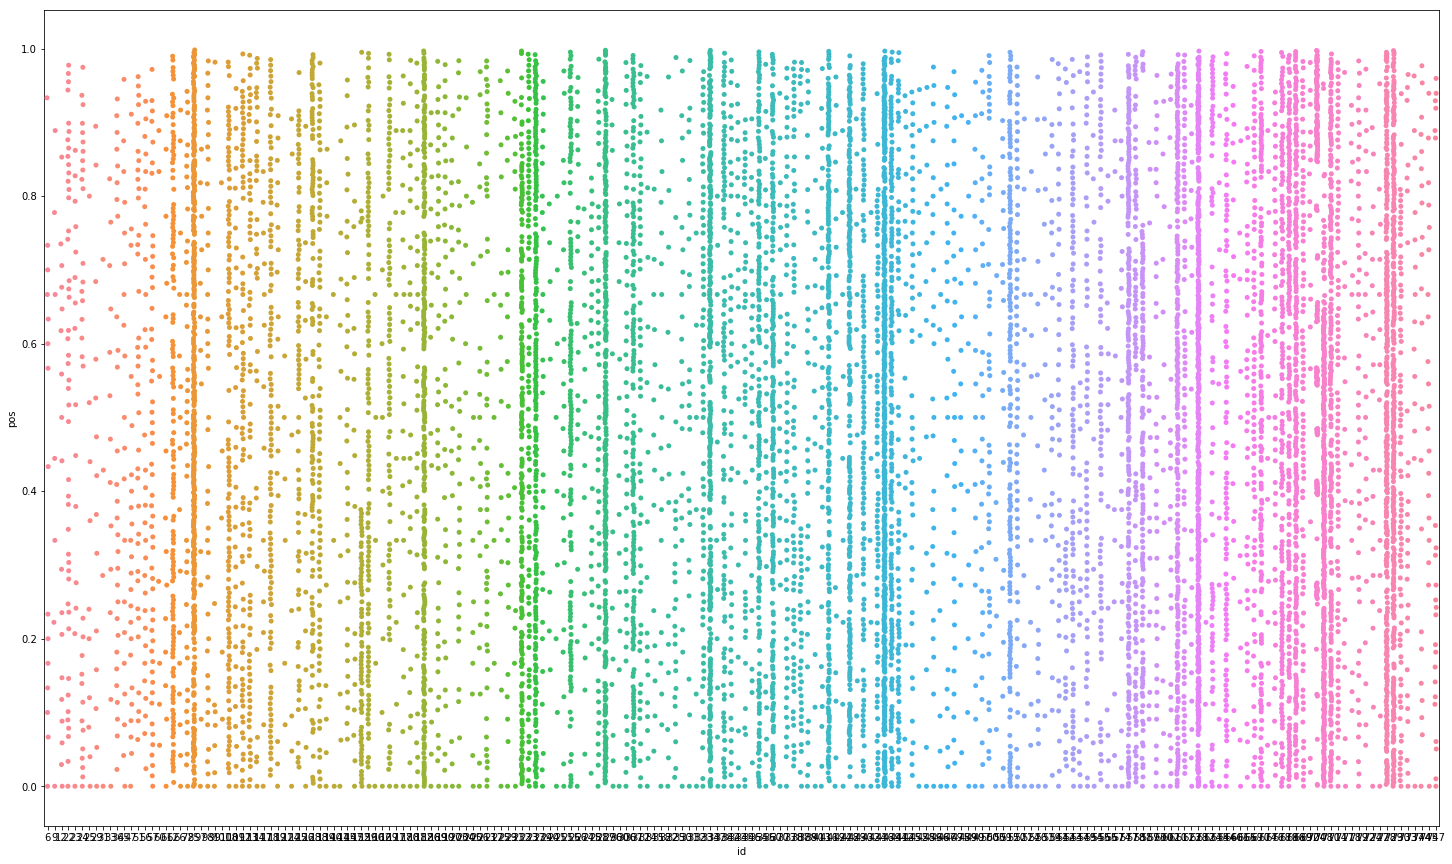

In [49]:
f, ax = plt.subplots(figsize=(25, 15), facecolor='w')
ax = sns.stripplot(x="id", y="pos", data=position_df)

## Strip Short sents again

In [50]:
getFrom = 'EXPANDED_CANDIDATES_0.95'
convertTo = getFrom + '_stripped'
secondary_sentence_length_threshold = len('i consent')

df[convertTo] = df.apply(lambda row:removeShortSentences(row, getFrom, secondary_sentence_length_threshold),axis=1)

In [51]:
for sent in df['EXPANDED_CANDIDATES_0.95_stripped'].head(1):
    print('-----------------')
    [print(x, '\n') for x in sent[:10]]

-----------------
no, i do not consent because: date: my child will recieve vaccine from the family doctor / 

vaccination consent form / v2018 gold coast health | public health unit school immunisation program consent form year 7 consent for vaccination: parent/legal guardian to read and sign i am authorised as the parent or legal guardian of the listed child to give consent for the child to be vaccinated. 

if i wish to change consent: - up to 2 business days before immunisation takes place at the school, i understand i need to do so by making a written request via email to gold coast public health unit at immunisegc@health.qld.gov.au 

yes, i consent parent/legal guardian signature: 

i understand that queensland health will record immunisation details, forward them to the australian immunisation register and vaccine monitoring service for the purpose of clinical follow up or disease prevention, control and monitoring. 

. - within 2 business days of immunisation, i understand that

### How many are there?

In [52]:
cand_count = 0
total_count = 0

for sent in df['sentenceList']:
    total_count += len(sent)
    
for cand_sent in df['EXPANDED_CANDIDATES_0.95_stripped']:
    cand_count += len(cand_sent)

print('number of total sentences (including short sentences):', total_count)
print('number of candidate sentences:', cand_count)
print('percentage:', cand_count/total_count)

number of total sentences (including short sentences): 19221
number of candidate sentences: 11478
percentage: 0.5971593569533323


## print candidate statements to file

In [53]:
today = str(datetime.date.today())

file_path = '../data/outputs/candidate_statements-'+today+'.csv'
print(file_path)

with open(file_path, 'w') as outcsv:   
    #configure writer to write standard csv file
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['file_id','candidate_statement'])
    for index, row in df.iterrows():
        for candidate in row['EXPANDED_CANDIDATES_0.95_stripped']:
            formatted_idx = "[[fileID:" + str(index) + "]]"
            writer.writerow([formatted_idx, candidate])

../data/outputs/candidate_statements-2019-03-26.csv


### Print run metadata to file

In [54]:
file_path = '../data/outputs/run_metadata-'+today+'.csv'
print(file_path)

tuneable_parameters = {
        'preliminary sentence threshold':preliminary_sentence_length_thresh,
        'candidate similarity threshold':sim_threshold,
        'secondary sentence threshold':secondary_sentence_length_threshold,
}
with open(file_path, 'w') as outcsv: 
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['variable','value'])
    
    for k,v in tuneable_parameters.items():
        writer.writerow([k,v])
        

../data/outputs/run_metadata-2019-03-26.csv


### print semantic clues to file

In [55]:
file_path = '../data/outputs/semantic_clues-'+today+'.csv'
print(file_path)

with open(file_path, 'w') as outcsv: 
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['clue','definition'])
    
    for word in permission_extended:
        syns = wordnet.synsets(word)
        for word_sense in syns:
            writer.writerow([word,word_sense.definition()])

../data/outputs/semantic_clues-2019-03-26.csv


### Print file IDs to file

In [56]:
file_path = '../data/outputs/file_ids-'+today+'.csv'
print(file_path)

with open(file_path, 'w') as outcsv: 
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['fileID','name', 'path'])
    
    for index, row in raw_df.iterrows():
        writer.writerow([index,row['name'], row['path']])

../data/outputs/file_ids-2019-03-26.csv


## print info about samples to file

In [58]:
file_path = '../data/outputs/sample_metadata-'+today+'.csv'
print(file_path)

with open(file_path, 'w') as outcsv: 
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['fileID',
                     'name', 
                     'path', 
                     'num_candidates',
                     'num_sentences'])
    
    for index, row in df.iterrows():
        writer.writerow([index,row['name'], 
                         row['path'], 
                         len(row['EXPANDED_CANDIDATES_0.95_stripped']),
                         len(row['sentenceList'])])

../data/outputs/sample_metadata-2019-03-26.csv


# Annotations?

This is the point where injecting further information via annotations may be a good idea. This then would require in import of another local file and a small methods section.